In [406]:
import sys
import os
threads_n='8'
os.environ["OMP_NUM_THREADS"] = threads_n # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = threads_n # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = threads_n # export MKL_NUM_THREADS=6

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pickle

import importlib
import monti
import montiutils

import matplotlib as mpl
import matplotlib.pyplot as plt

# set project parameters
cancer_type='COAD'
metadir='../metadata'              # path to metadata such as mirna-gene target file, promoter methylation probes file
ddir='../dataset/%s'%(cancer_type) # path to raw omics data
odir='./tutorial_COAD'             # output directory

In [407]:
# loading raw omics data

# gene expression data
mrna_df=pd.read_csv('%s/omics_gene_mat.txt'%(ddir), header=0)
mrna_df

,ID,TCGA-A6-2672,TCGA-A6-3809,TCGA-A6-5661,TCGA-A6-5665,TCGA-A6-6653,TCGA-A6-6780,TCGA-AA-3492,TCGA-AA-3713,TCGA-AD-5900,...,TCGA-F5-6813,TCGA-F5-6864,TCGA-G4-6297,TCGA-G4-6302,TCGA-G4-6310,TCGA-G4-6311,TCGA-G4-6314,TCGA-G4-6627,TCGA-G5-6572,TCGA-NH-A50V
0,ENSG00000078237,110401.035821,229114.170428,35151.127880,124802.381456,103611.773339,290031.453338,170634.872215,55397.296453,72444.215132,...,120431.166887,111181.479363,143777.466036,107683.404593,62363.410574,118619.205619,137123.430933,233644.779886,59163.471695,124297.706478
1,ENSG00000146083,357042.207722,282965.214392,304678.123387,302038.713978,355184.598513,186884.517162,183503.375005,421782.715171,271248.648279,...,478390.867083,480510.132038,444977.892233,251259.920060,370879.916585,416314.697822,598013.104648,302838.183007,577164.964464,674501.236994
2,ENSG00000201788,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,ENSG00000172137,10807.344671,10845.365233,0.000000,89370.060652,1349.882898,12060.571204,12279.504024,14550.895983,9018.415605,...,66477.967622,24555.075514,86363.751763,332448.180027,11551.456927,83038.250977,126339.175395,97461.684806,3577.365904,6793.140450
4,ENSG00000060642,83807.091313,82697.627826,170115.927945,85567.435696,71541.698104,84643.536840,162483.964155,133541.895047,133713.314617,...,106119.475389,114864.261701,78428.920267,104562.382194,135238.630745,120629.383393,131236.851308,97541.764081,130728.440487,134227.232886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14508,ENSG00000135094,60002.693998,160189.734866,46459.894884,54196.715536,30016.595162,36725.863634,81935.074570,112085.979919,41820.038346,...,28754.391784,56685.196615,94144.157482,127574.671111,9543.754022,62165.231826,39614.051104,107678.472768,23162.262652,73892.012366
14509,ENSG00000238244,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14510,ENSG00000273233,31682.940177,6193.714618,0.000000,12579.945554,4047.272139,6026.746702,5454.354552,0.000000,1335.277497,...,0.000000,917.408047,0.000000,0.000000,0.000000,1317.293962,0.000000,0.000000,0.000000,2172.529237
14511,ENSG00000105063,370353.457362,385176.979002,227369.617735,251386.410708,742857.342406,115051.079754,628274.034603,572290.155116,407589.652874,...,428228.049455,342787.572704,519644.397593,377542.609397,337805.026858,500302.363688,455924.833658,372696.995693,229710.543562,683262.590115


In [409]:
# methylation expression data
meth_df=pd.read_csv('%s/omics_methylation_mat.txt'%(ddir), header=0)
meth_df

,ID,TCGA-A6-2672,TCGA-A6-3809,TCGA-A6-5661,TCGA-A6-5665,TCGA-A6-6653,TCGA-A6-6780,TCGA-AA-3492,TCGA-AA-3713,TCGA-AD-5900,...,TCGA-F5-6813,TCGA-F5-6864,TCGA-G4-6297,TCGA-G4-6302,TCGA-G4-6310,TCGA-G4-6311,TCGA-G4-6314,TCGA-G4-6627,TCGA-G5-6572,TCGA-NH-A50V
0,cg00000292,0.772949,0.833656,0.865206,0.867518,0.818789,0.857952,0.667273,0.725979,0.768619,...,0.769446,0.769979,0.586474,0.732069,0.801578,0.718911,0.809942,0.773792,0.620910,0.800947
1,cg00000957,0.921157,0.925428,0.933994,0.906477,0.941089,0.929394,0.917511,0.894362,0.927925,...,0.940588,0.908667,0.859605,0.898686,0.850668,0.910475,0.896367,0.889975,0.918739,0.934531
2,cg00001245,0.027591,0.025430,0.027493,0.024328,0.014894,0.049371,0.014147,0.026954,0.064157,...,0.013115,0.010809,0.019329,0.014906,0.015579,0.013817,0.014068,0.019387,0.013119,0.019381
3,cg00001261,0.692554,0.659905,0.789700,0.730600,0.878936,0.767750,0.731054,0.534501,0.654352,...,0.718754,0.679518,0.684676,0.512591,0.720083,0.696882,0.620999,0.588251,0.712579,0.674175
4,cg00001510,0.392426,0.301930,0.347993,0.417096,0.499358,0.379856,0.408575,0.258008,0.690483,...,0.339302,0.240697,0.348286,0.395791,0.222975,0.280361,0.343096,0.467187,0.493389,0.423878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62064,ch.X.68408155R,0.023537,0.027776,0.035819,0.028448,0.053986,0.055547,0.029064,0.042174,0.051987,...,0.063085,0.048179,0.029422,0.033519,0.033661,0.030785,0.027396,0.035947,0.054844,0.044122
62065,rs10774834,0.020738,0.967531,0.487582,0.033290,0.033505,0.552675,0.020564,0.464194,0.044497,...,0.487284,0.496748,0.962881,0.457255,0.040253,0.031178,0.033565,0.482852,0.026399,0.967329
62066,rs6546473,0.021268,0.018899,0.970349,0.026803,0.474116,0.022337,0.021825,0.430641,0.466020,...,0.460663,0.021852,0.031364,0.020243,0.916626,0.459151,0.536227,0.020599,0.021929,0.960970
62067,rs939290,0.961978,0.024054,0.550272,0.545858,0.039577,0.870512,0.540014,0.504772,0.943834,...,0.962997,0.452268,0.031774,0.492199,0.960924,0.699910,0.531172,0.501374,0.518952,0.964920


In [410]:
# mirna expression data
mir_df=pd.read_csv('%s/omics_mirna_mat.txt'%(ddir), header=0)
mir_df

,ID,TCGA-A6-2672,TCGA-A6-3809,TCGA-A6-5661,TCGA-A6-5665,TCGA-A6-6653,TCGA-A6-6780,TCGA-AA-3492,TCGA-AA-3713,TCGA-AD-5900,...,TCGA-F5-6813,TCGA-F5-6864,TCGA-G4-6297,TCGA-G4-6302,TCGA-G4-6310,TCGA-G4-6311,TCGA-G4-6314,TCGA-G4-6627,TCGA-G5-6572,TCGA-NH-A50V
0,hsa-let-7a-1,7167.498389,3329.021019,6134.637434,5010.243033,10149.119285,3309.138457,5794.210865,11001.305158,5947.926015,...,13512.020938,10615.213522,7386.611190,3147.074973,2356.278528,5814.019056,4076.455482,4366.972544,16590.373170,5431.393581
1,hsa-let-7a-2,7118.344348,3385.379975,6105.224789,4996.978674,10131.932704,3239.737762,5773.408787,10916.622652,5971.260574,...,13552.824334,10578.013066,7324.162998,3135.428080,2306.183842,5797.825627,4111.289565,4378.987601,16638.999118,5393.418131
2,hsa-let-7a-3,7243.027769,3477.603720,6180.332079,5022.033574,10183.669629,3268.347844,5678.135268,10979.479770,5949.251842,...,13495.605779,10676.140253,7361.054834,3157.756321,2397.597503,5822.983275,4099.264988,4388.916711,16784.415322,5423.557377
3,hsa-let-7b,11394.146473,12762.741607,8605.824859,6794.299273,11665.613619,3084.790087,7402.211511,14181.700722,8215.223121,...,8068.050683,7287.871968,10262.113403,3146.773240,3206.425576,8992.268506,4592.520565,3424.958711,15769.887243,3935.281394
4,hsa-let-7c,186.425692,170.357751,266.289485,215.177374,147.591983,151.831725,251.705146,175.476121,542.263328,...,1487.916919,879.141480,525.347989,772.376080,483.943922,357.701262,864.405914,428.370153,3491.527698,525.779152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,hsa-mir-9500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1877,hsa-mir-96,48.554601,2.561771,43.068516,56.005070,17.363763,22.378183,17.057704,3.928570,6.098805,...,22.746720,5.174867,8.656185,1.508665,12.615085,9.542556,14.751800,4.672522,19.696586,25.919752
1878,hsa-mir-98,34.767492,34.583904,42.018065,41.266894,74.770488,45.889439,41.604156,45.396807,34.206342,...,46.900454,32.318506,40.807729,27.638741,32.908918,61.592861,46.982625,26.032623,57.704843,34.509437
1879,hsa-mir-99a,83.322094,51.235414,115.024452,112.747049,22.324838,78.748544,60.326027,31.865067,119.987362,...,237.550802,305.219488,97.279031,124.615720,140.777038,88.196350,156.691392,123.654960,817.562215,193.041873


In [412]:
# load mRNA data
gene_gl=pd.read_csv('%s/omics_gene_mat.txt'%(ddir), header=0, index_col=0)
gene_gl

,TCGA-A6-2672,TCGA-A6-3809,TCGA-A6-5661,TCGA-A6-5665,TCGA-A6-6653,TCGA-A6-6780,TCGA-AA-3492,TCGA-AA-3713,TCGA-AD-5900,TCGA-AD-6889,...,TCGA-F5-6813,TCGA-F5-6864,TCGA-G4-6297,TCGA-G4-6302,TCGA-G4-6310,TCGA-G4-6311,TCGA-G4-6314,TCGA-G4-6627,TCGA-G5-6572,TCGA-NH-A50V
ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000078237,110401.035821,229114.170428,35151.127880,124802.381456,103611.773339,290031.453338,170634.872215,55397.296453,72444.215132,97317.928135,...,120431.166887,111181.479363,143777.466036,107683.404593,62363.410574,118619.205619,137123.430933,233644.779886,59163.471695,124297.706478
ENSG00000146083,357042.207722,282965.214392,304678.123387,302038.713978,355184.598513,186884.517162,183503.375005,421782.715171,271248.648279,292782.843283,...,478390.867083,480510.132038,444977.892233,251259.920060,370879.916585,416314.697822,598013.104648,302838.183007,577164.964464,674501.236994
ENSG00000201788,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000172137,10807.344671,10845.365233,0.000000,89370.060652,1349.882898,12060.571204,12279.504024,14550.895983,9018.415605,4293.960223,...,66477.967622,24555.075514,86363.751763,332448.180027,11551.456927,83038.250977,126339.175395,97461.684806,3577.365904,6793.140450
ENSG00000060642,83807.091313,82697.627826,170115.927945,85567.435696,71541.698104,84643.536840,162483.964155,133541.895047,133713.314617,81665.232258,...,106119.475389,114864.261701,78428.920267,104562.382194,135238.630745,120629.383393,131236.851308,97541.764081,130728.440487,134227.232886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000135094,60002.693998,160189.734866,46459.894884,54196.715536,30016.595162,36725.863634,81935.074570,112085.979919,41820.038346,19648.510601,...,28754.391784,56685.196615,94144.157482,127574.671111,9543.754022,62165.231826,39614.051104,107678.472768,23162.262652,73892.012366
ENSG00000238244,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000273233,31682.940177,6193.714618,0.000000,12579.945554,4047.272139,6026.746702,5454.354552,0.000000,1335.277497,0.000000,...,0.000000,917.408047,0.000000,0.000000,0.000000,1317.293962,0.000000,0.000000,0.000000,2172.529237


In [414]:
# converting methylation data to gene-level
methylation_promoter_probes_file='%s/promoter_probes_illumina450.txt'%(metadir)
gid_tid_file='%s/gid_tid.txt'%(metadir)
methylation_gl=monti.make_methylation_gcentric('%s/omics_methylation_mat.txt'%(ddir), '%s/omics_gene_mat.txt'%(ddir), gid_tid_file, methylation_promoter_probes_file)
methylation_gl

reading methylation data...
reading TSS promoter probe annotation...
converting methylation to gene level data...


,TCGA-A6-2672,TCGA-A6-3809,TCGA-A6-5661,TCGA-A6-5665,TCGA-A6-6653,TCGA-A6-6780,TCGA-AA-3492,TCGA-AA-3713,TCGA-AD-5900,TCGA-AD-6889,...,TCGA-F5-6813,TCGA-F5-6864,TCGA-G4-6297,TCGA-G4-6302,TCGA-G4-6310,TCGA-G4-6311,TCGA-G4-6314,TCGA-G4-6627,TCGA-G5-6572,TCGA-NH-A50V
ENSG00000078237,0.274113,0.229859,0.358540,0.298859,0.276716,0.278641,0.221814,0.266945,0.267733,0.375971,...,0.301767,0.292087,0.267257,0.469085,0.385926,0.363512,0.302895,0.383078,0.305392,0.256602
ENSG00000146083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000201788,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000172137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000060642,0.832104,0.853962,0.897067,0.871596,0.928627,0.857895,0.889566,0.790942,0.794422,0.882483,...,0.896202,0.868366,0.869653,0.813293,0.895842,0.865300,0.832999,0.808799,0.883244,0.847925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000135094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000238244,0.828696,0.790584,0.945221,0.864825,0.928421,0.926283,0.904927,0.783388,0.814290,0.905566,...,0.936541,0.915967,0.899094,0.917111,0.920304,0.906826,0.891333,0.892311,0.931168,0.910159
ENSG00000273233,0.612857,0.413215,0.601247,0.410201,0.661609,0.585774,0.325969,0.568330,0.596693,0.742164,...,0.620149,0.488283,0.390526,0.566556,0.491179,0.391207,0.414622,0.553726,0.218604,0.571626
ENSG00000105063,0.600436,0.635908,0.879934,0.905830,0.836184,0.788373,0.897349,0.625818,0.873850,0.919221,...,0.891600,0.737308,0.844982,0.846924,0.897698,0.788975,0.754224,0.791312,0.912131,0.884942


In [415]:
# converting miRNA data to gene-level
mirna_gene_target_file='%s/mirna_gene_pairs.txt'%(metadir)
mirna_gl=monti.make_mir_gcentric('%s/omics_mirna_mat.txt'%(ddir), '%s/omics_gene_mat.txt'%(ddir), mirna_gene_target_file)
mirna_gl

reading mirna file...
reading mirna gene target file...
converting miRNAs to gene level data...


,TCGA-A6-2672,TCGA-A6-3809,TCGA-A6-5661,TCGA-A6-5665,TCGA-A6-6653,TCGA-A6-6780,TCGA-AA-3492,TCGA-AA-3713,TCGA-AD-5900,TCGA-AD-6889,...,TCGA-F5-6813,TCGA-F5-6864,TCGA-G4-6297,TCGA-G4-6302,TCGA-G4-6310,TCGA-G4-6311,TCGA-G4-6314,TCGA-G4-6627,TCGA-G5-6572,TCGA-NH-A50V
ENSG00000078237,1.798319,2.561771,3.501505,3.930180,1.889933,3.304795,1.248125,1.164021,1.193244,1.354535,...,1.328846,2.148058,1.305298,1.146585,2.437698,3.951968,1.115682,1.223756,22.107367,1.255802
ENSG00000146083,1812.750079,1347.939696,1716.346025,1543.326554,2379.739111,1277.440185,1631.059749,2374.929613,1574.028689,1866.049383,...,2806.400083,1819.646625,1973.507128,984.821745,1255.630625,1807.201044,1632.748476,1258.354011,3522.896051,1853.797228
ENSG00000201788,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000172137,2461.938088,2531.029447,2589.818428,2490.653540,2320.389298,3073.572668,2053.941730,3242.437867,2113.563022,1474.320759,...,1991.596533,1549.120712,2183.790593,1993.911873,3310.210553,2830.746192,2469.310884,2124.901745,2733.824640,3126.163186
ENSG00000060642,1344.775968,1311.341955,1441.919917,1396.401265,1250.348407,1645.126957,1078.171714,1703.641299,1252.567888,765.330939,...,1110.654874,813.886087,1142.719468,1108.318874,1715.377350,1516.061519,1338.288561,1177.915940,1414.033667,1594.952172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000135094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000238244,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000273233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000105063,1864.931289,700.163953,1958.501384,1314.737439,1460.925864,3026.507666,893.969311,1026.611696,615.913029,1749.445106,...,750.612461,697.813668,926.160269,218.152944,373.836167,1009.595184,748.498911,323.186256,1382.684977,1235.200500


In [416]:
# create an multi-omics data object including all omics data
modata={'gene':gene_gl, 'methylation':methylation_gl, 'mirna':mirna_gl}

# load clinical features
label_data=pd.read_csv('%s/subtypes.txt'%(ddir), header=0)

# load list of genes to use for the analysis
genelist=pd.read_csv('%s/genelist.txt'%(metadir), header=0)

In [417]:
# the group labels
label_data

,Sampid,Class
0,TCGA-A6-2672,CMS1
1,TCGA-A6-3809,CMS1
2,TCGA-A6-5661,CMS1
3,TCGA-A6-5665,CMS1
4,TCGA-A6-6653,CMS1
...,...,...
310,TCGA-G4-6311,CMS4
311,TCGA-G4-6314,CMS4
312,TCGA-G4-6627,CMS4
313,TCGA-G5-6572,CMS4


In [418]:
# the gene list
genelist

,ENSGID,GeneSymbol
0,ENSG00000000419,DPM1
1,ENSG00000000460,C1orf112
2,ENSG00000000938,FGR
3,ENSG00000001167,NFYA
4,ENSG00000001460,STPG1
...,...,...
14508,ENSG00000280893,AC009133.6
14509,ENSG00000280987,MATR3
14510,ENSG00000281005,LINC00921
14511,ENSG00000281028,AC104662.2


In [419]:
# create environment for saving results
cv_n=10 # n cross validation
montiutils.make_env(odir, cv_n) # creating directories

# split data into train and test data sets for cross validation
cv_data=montiutils.split_data(modata, label_data, genelist, odir, cv_n)

generating cross validation data set 0...
generating cross validation data set 1...
generating cross validation data set 2...
generating cross validation data set 3...
generating cross validation data set 4...
generating cross validation data set 5...
generating cross validation data set 6...
generating cross validation data set 7...
generating cross validation data set 8...
generating cross validation data set 9...


In [424]:
# set parameters
rank=80		# number of ranks (or features) to decompose the tensor
maxiter=50	# number of maximum iterations while decomposing the tensor (higher the better)
tol_val=10e-6	# the tolerance value when decomposition does not change under @tol_val (smaller the better)
alpha=0.01  # the penalty value for feature selection (L1 regression). Higher value penalizes features more, causing less number of features to be selected

# perform n cross validation
for i in range(cv_n):
	print('cv: ', i)
	tres=monti.decompose_tensor(cv_data[i].train_data, rank, maxiter, tol_val)
	np.save('%s/cvs/cv_%d/out/components/r%d_td.npy'%(odir, i, rank), tres)
	O, G, P=tres
	sample_info=monti.get_sample_info(modata.keys(), cv_data[i].train_labels, genelist)
	feature_samples, feature_labels=monti.select_features(P, alpha, sample_info, odir, i)
	feature_genes, gene_labels=monti.get_featuregenes(G, cv_data[i], sample_info, odir, i, rank)
	predres=monti.measure_accuracy(cv_data[i], feature_genes, sample_info, odir, i)
	
	# store results to cross validation data sets
	cv_data[i].sample_info=sample_info
	cv_data[i].feature_samples=feature_samples
	cv_data[i].feature_labels=feature_labels
	cv_data[i].feature_genes=feature_genes
	cv_data[i].gene_labels=gene_labels
	cv_data[i].predres=predres


cv:  0
Selected features:	20
Selected genes:	3735
  - CMS1: 521 genes
  - CMS2: 1883 genes
  - CMS3: 2530 genes
  - CMS4: 1875 genes
---------------

cv:  1
Selected features:	23
Selected genes:	4829
  - CMS1: 1700 genes
  - CMS2: 958 genes
  - CMS3: 1157 genes
  - CMS4: 1875 genes
---------------

cv:  2
Selected features:	20
Selected genes:	2446
  - CMS1: 481 genes
  - CMS2: 833 genes
  - CMS3: 1250 genes
  - CMS4: 899 genes
---------------

cv:  3
Selected features:	20
Selected genes:	3483
  - CMS1: 926 genes
  - CMS2: 1311 genes
  - CMS3: 824 genes
  - CMS4: 1820 genes
---------------

cv:  4
Selected features:	19
Selected genes:	3386
  - CMS1: 608 genes
  - CMS2: 2366 genes
  - CMS3: 593 genes
  - CMS4: 2197 genes
---------------

cv:  5
Selected features:	21
Selected genes:	3520
  - CMS1: 451 genes
  - CMS2: 1739 genes
  - CMS3: 1160 genes
  - CMS4: 1150 genes
---------------

cv:  6
Selected features:	23
Selected genes:	3960
  - CMS1: 1516 genes
  - CMS2: 1768 genes
  - CMS3: 10

In [433]:
# let's observe the results of cross validation data set #0 (cv0)
cvidx=0
print(cv_data[cvidx].predres)

              precision    recall  f1-score   support

        CMS1       1.00      0.67      0.80         3
        CMS2       0.47      0.78      0.58         9
        CMS3       1.00      0.50      0.67        10
        CMS4       0.78      0.78      0.78         9

    accuracy                           0.68        31
   macro avg       0.81      0.68      0.71        31
weighted avg       0.78      0.68      0.69        31



In [434]:
# load the decomposition result of cv0
O, G, P=np.load('%s/cvs/cv_%d/out/components/r%d_td.npy'%(odir, cvidx, rank), allow_pickle=True)

print('O:', O.shape)
print('P:', P.shape)
print('G:', G.shape)

O: (3, 80)
P: (286, 80)
G: (14513, 80)


In [435]:
# the test labels
cv_data[cvidx].test_labels

,Sampid,Class
0,TCGA-A6-5661,CMS1
1,TCGA-A6-6653,CMS1
2,TCGA-AZ-4616,CMS1
3,TCGA-F5-6863,CMS2
4,TCGA-F5-6863,CMS2
5,TCGA-DY-A1DC,CMS2
6,TCGA-CA-6715,CMS2
7,TCGA-CK-5915,CMS2
8,TCGA-AD-6888,CMS2
9,TCGA-A6-A567,CMS2


In [436]:
# the selected features and associated groups from Cp
# here, we can see that feature #6 is associated both with CMS2 and CMS4
cv_data[cvidx].feature_labels

,FeatureIndex,Group
0,2,CMS1
1,8,CMS1
2,20,CMS1
3,35,CMS1
4,67,CMS1
5,77,CMS1
6,78,CMS1
7,8,CMS2
8,26,CMS2
9,42,CMS2


In [437]:
cv_data[cvidx].gene_labels

,ENSGID,GeneSymbol,GeneIndex,Group
0,ENSG00000002822,MAD1L1,11,CMS1
1,ENSG00000011275,RNF216,160,CMS1
2,ENSG00000015676,NUDCD3,208,CMS1
3,ENSG00000027075,PRKCH,248,CMS1
4,ENSG00000028528,SNX1,253,CMS1
...,...,...,...,...
6804,ENSG00000277669,AC009086.2,14488,CMS4
6805,ENSG00000278318,ZNF229,14494,CMS4
6806,ENSG00000278615,C11orf98,14498,CMS4
6807,ENSG00000280893,AC009133.6,14508,CMS4


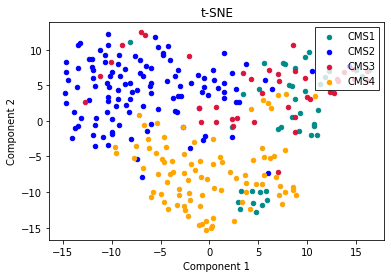

In [438]:
p=montiutils.plot_sample_features(P, cv_data[cvidx].feature_labels, cv_data[cvidx].train_labels, cv_data[cvidx].sample_info)
p.show()


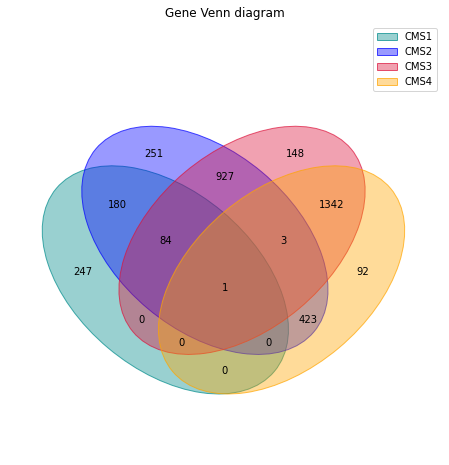

In [440]:
# plot venn diagrm of genes
p=montiutils.plot_venn(cv_data[cvidx].gene_labels, cv_data[cvidx].sample_info)
plt.show()

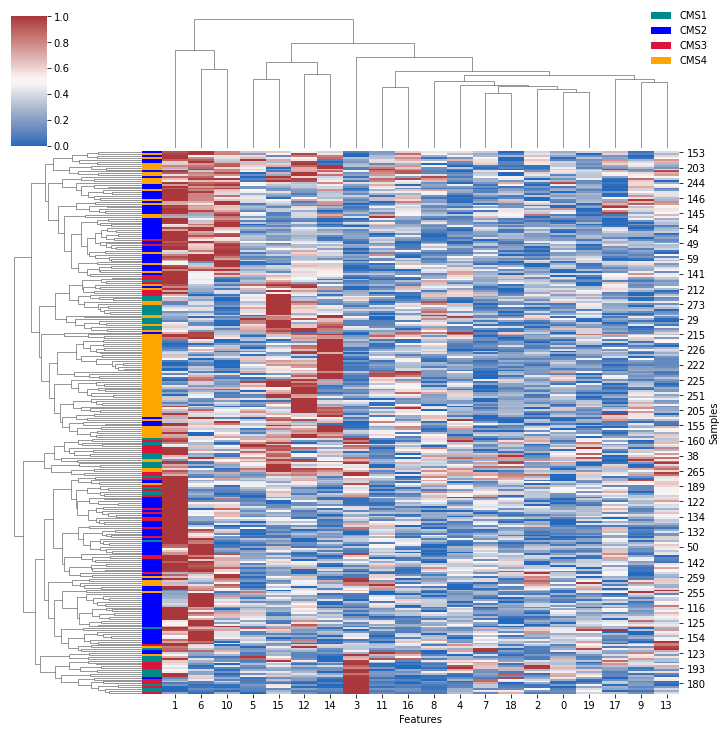

In [441]:
# plot sample heatmap (P component)
p=montiutils.plot_sample_hmap(P, cv_data[cvidx].feature_samples, cv_data[cvidx].sample_info)
p.show()

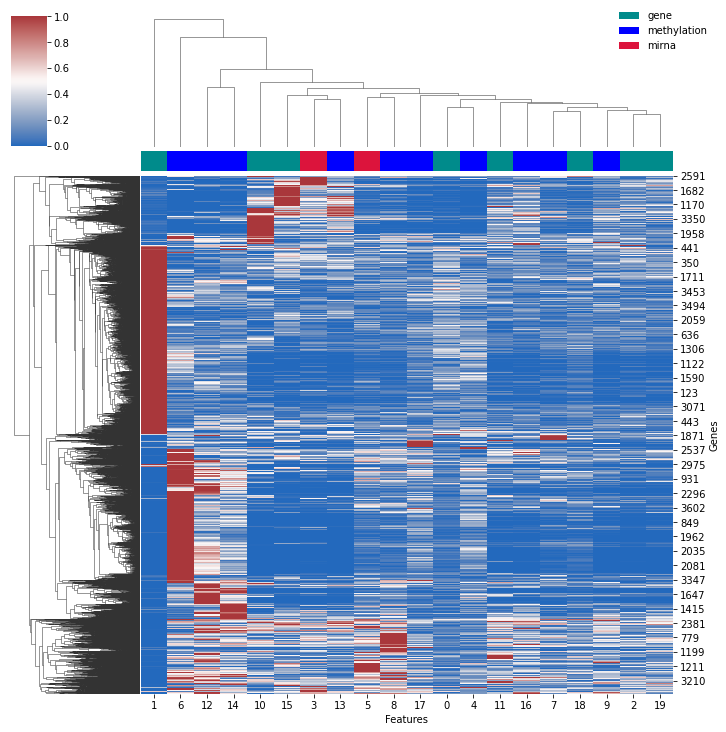

In [442]:
# plot gene heatmap (G component)
p=montiutils.plot_gene_hmap(G, O, cv_data[cvidx].feature_samples, cv_data[cvidx].feature_genes, cv_data[cvidx].sample_info)
p.show()

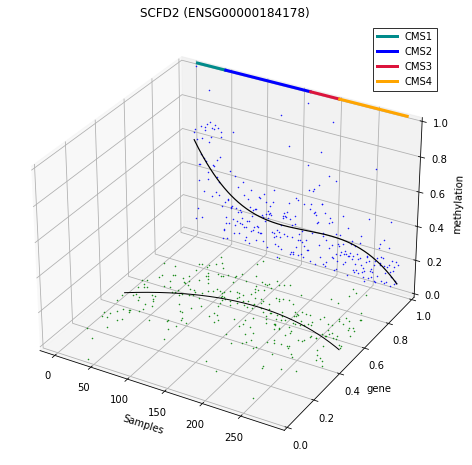

In [453]:
gidx=feature_genes[9]
montiutils.plot_gene(modata, cv_data[cvidx], gidx, cv_data[cvidx].sample_info)